In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [3]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
# where WellClass and Ga[ codes are located
sys.path.append('../src')

In [5]:
# WellClass
# from well_class_v2 import csv_parser, Well
from WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from WellClass.libs.well_class import Well
from WellClass.libs.well_pressure import Pressure

# plots
from WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [6]:
# use yaml or csv input file
use_yaml = False

In [7]:
# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

case_type = 'smeaheia_v2'

case_type = 'frigg'

In [8]:
# where pvt located
pvt_path = '../test_data/pvt_constants/'

# Examples

The following are the test examples.

In [9]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
cosmo = {
         'well_input': r'GaP_input_Cosmo_v3.csv', 
         'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/cosmo', 
         'simcase': r'TEMP-0'}

frigg = {
         'well_input': r'GaP_input_Frigg_v3.csv', 
         'sim_path': r'../test_data/examples/frigg', }

In [10]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo,
    'frigg': frigg
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [11]:
# the selected example for testing
case = examples[case_type]


In [12]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [13]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [14]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

In [15]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
)

Hydrostatic pressure at reference depth 1217 is 120.23
RP1 set as hydrostatic P = 120.23 bar
Reference depth: 1217.0


# Visualization

## to do
Verify cement plugs computation

In [16]:
a ="Wellname       UWN            UTMnorth       UTMeast        MeasDepth(m)   MeasTVD(m)     Dip            Azimuth        Location(NS)   Location(EW)   Dogleg"
a.split()


['Wellname',
 'UWN',
 'UTMnorth',
 'UTMeast',
 'MeasDepth(m)',
 'MeasTVD(m)',
 'Dip',
 'Azimuth',
 'Location(NS)',
 'Location(EW)',
 'Dogleg']

In [17]:
import welly
import numpy as np

w = welly.Well()
survey = np.loadtxt(r'../test_data/examples/frigg/X_5687dev.txt', skiprows=1, dtype={'names':('Wellname',
                                                                                     'UWN',
                                                                                     'UTMnorth',
                                                                                     'UTMeast',
                                                                                     'MeasDepth(m)',
                                                                                     'MeasTVD(m)',
                                                                                     'Dip',
                                                                                     'Azimuth',
                                                                                     'Location(NS)',
                                                                                     'Location(EW)',
                                                                                     'Dogleg'),
                                                                             'formats':['|S10']+10*[float]})


w.location.add_deviation(  np.stack([survey['MeasDepth(m)'], survey['Dip'],survey['Azimuth']]).T, td=4721)

t = w.location.trajectory(elev=True, datum=(0, 0, my_well.header['well_rkb']))

w.location.md2tvd(4451)

array(4445.94119583)

In [18]:
import wellpathpy as wp


md, inc, azi = survey['MeasDepth(m)'], survey['Dip'],survey['Azimuth']

In [19]:
my_well.header['well_rkb']

27.0

In [20]:
my_well.header['well_name']

dev = wp.deviation(
    md = md,
    inc = inc,
    azi = azi
)

# The recommended method for most use-cases
pos = dev.minimum_curvature(course_length=30)

tvd = pos.depth
northing = pos.northing
easting = pos.easting


dev.md.shape
# wp.read_header_json
# # Comparison methods to contrast with older deviation surveys
# tvd, northing, easting      = dev.radius_curvature()
# tvd, northing, easting      = dev.tan_method() # for the default 'avg' method
# tvd, northing, easting      = dev.tan_method(choice='bal')
# tvd, northing, easting      = dev.tan_method(choice='high')
# tvd, northing, easting      = dev.tan_method(choice='low')

(158,)

In [21]:
easting.shape

(158,)

In [22]:
a = np.stack([survey['MeasDepth(m)'], survey['Dip'],survey['Azimuth']])
a.shape

(3, 158)

In [23]:
w.location.tvd


array([   0.        ,  219.99899476,  247.99874112,  275.99847257,
        308.99819847,  335.99801551,  366.99705615,  421.9960542 ,
        448.99567622,  478.99390217,  508.99153258,  521.99130413,
        573.99058802,  654.9880008 ,  716.98689074,  763.98655375,
        810.98512607,  859.98416525,  906.98326788,  915.98310794,
        936.97941348,  945.97497213,  953.9716581 ,  961.96891269,
        971.96614061,  979.96374969,  993.9603915 , 1042.95293408,
       1081.94861431, 1213.94537412, 1297.94274643, 1326.94090421,
       1346.93981188, 1402.93560785, 1452.92522877, 1508.90605378,
       1546.89127674, 1575.87851395, 1666.84085624, 1756.80796588,
       1811.79038024, 1870.77148365, 1929.74989494, 1934.74806492,
       1982.7316343 , 2032.71337073, 2073.69738546, 2119.67841252,
       2172.65265447, 2222.63054708, 2265.61732992, 2302.58990552,
       2314.57757106, 2322.56836659, 2334.55300936, 2343.54026236,
       2352.52622474, 2382.48507723, 2401.46631448, 2410.45874

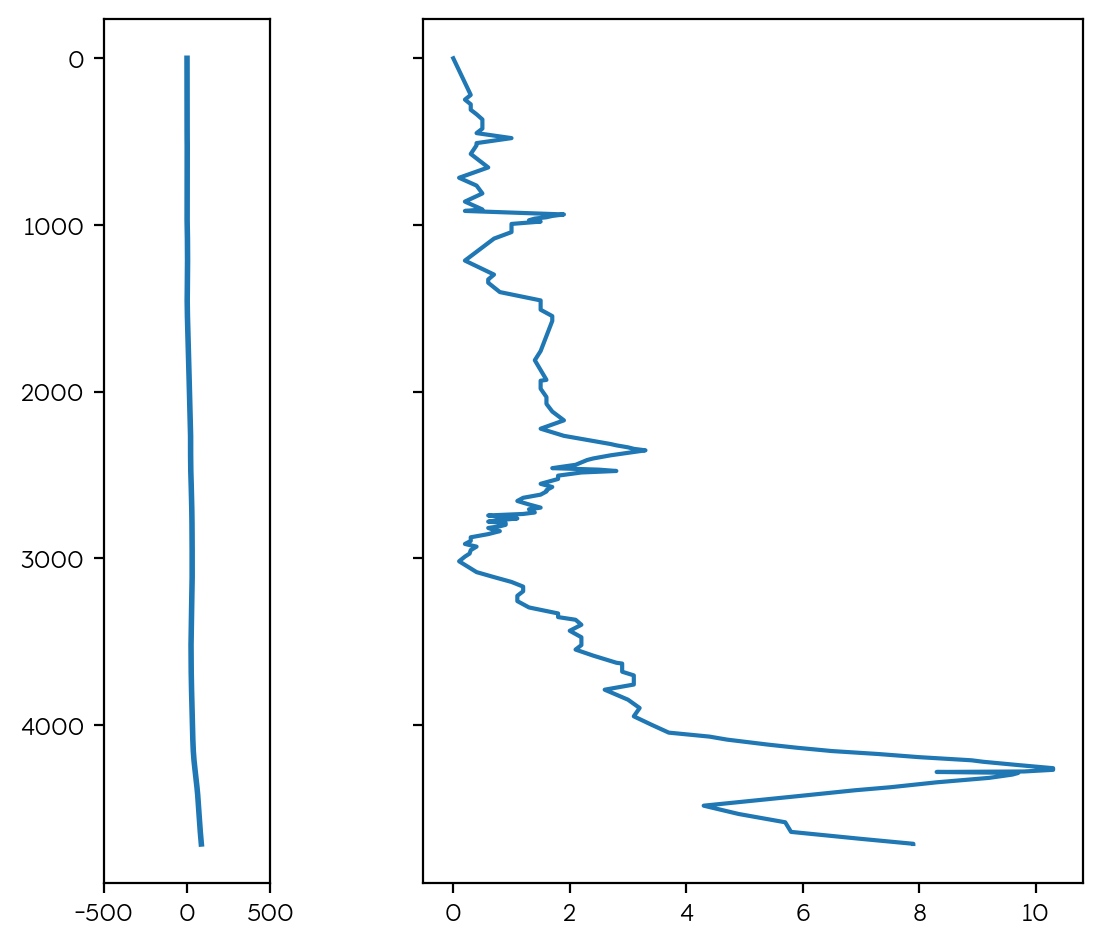

In [24]:
fig, (ax, ax2) = plt.subplots(1,2,sharey=True)
#MD
md_welly = w.location.deviation[:, 0]
w.location.tvd

#Horizontal offset of the well
os = np.sqrt(w.location.position[:,0]**2+w.location.position[:,1]**2)

ax.plot(os, w.location.tvd, lw=2, label="welly")

ax2.plot(w.location.deviation[:, 1], w.location.tvd, )
ax.set_xlim(-500, 500)
ax.set_aspect(1)
ax.invert_yaxis()

fig.tight_layout()


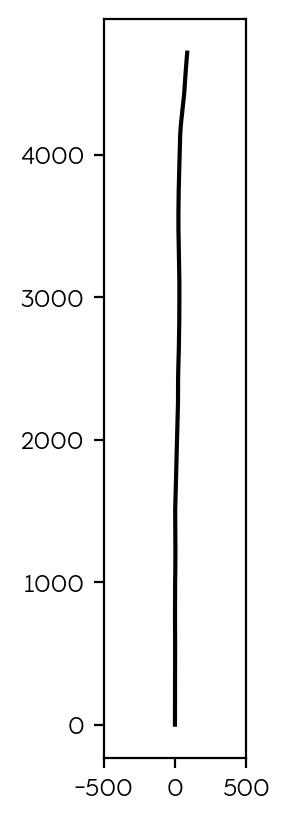

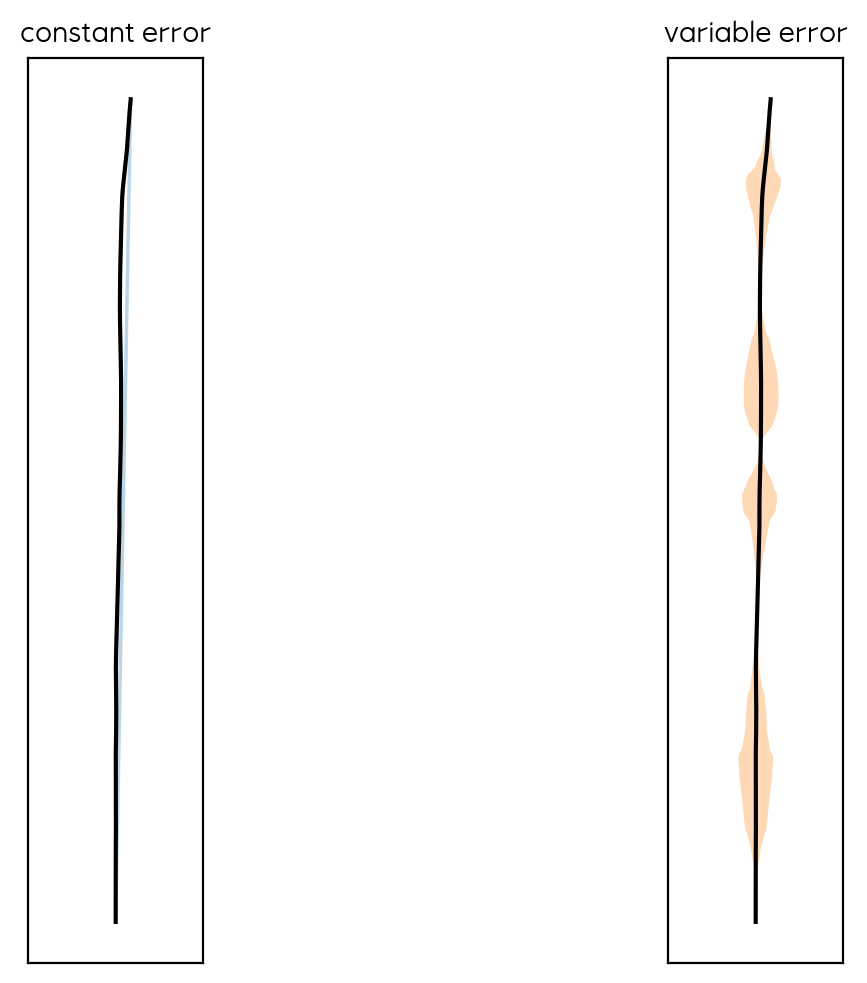

In [25]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

N = 400
t = np.linspace(0, 2 * np.pi, N)
r = 0.5 + np.cos(t)
x, y = r * np.cos(t), r * np.sin(t)
x, y = os, w.location.tvd
t = np.linspace(0, 2 * np.pi, len(x))

fig, ax = plt.subplots()
ax.plot(x, y, "k")
ax.set(aspect=1)
ax.set_xlim(-500, 500)

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))


_, axs = plt.subplots(1, 2, layout='constrained', sharex=True, sharey=True)
errs = [
    (axs[0], "constant error", 10),
    (axs[1], "variable error", 100 * np.sin(2 * t) ** 2 + 0.04),
]
for i, (ax, title, err) in enumerate(errs):
    ax.set(title=title, aspect=1, xticks=[], yticks=[])
    ax.plot(x, y, "k")
    draw_error_band(ax, x, y, err=err,
                    facecolor=f"C{i}", edgecolor="none", alpha=.3)
    
    ax.set_xlim(-500, 500)

plt.show()

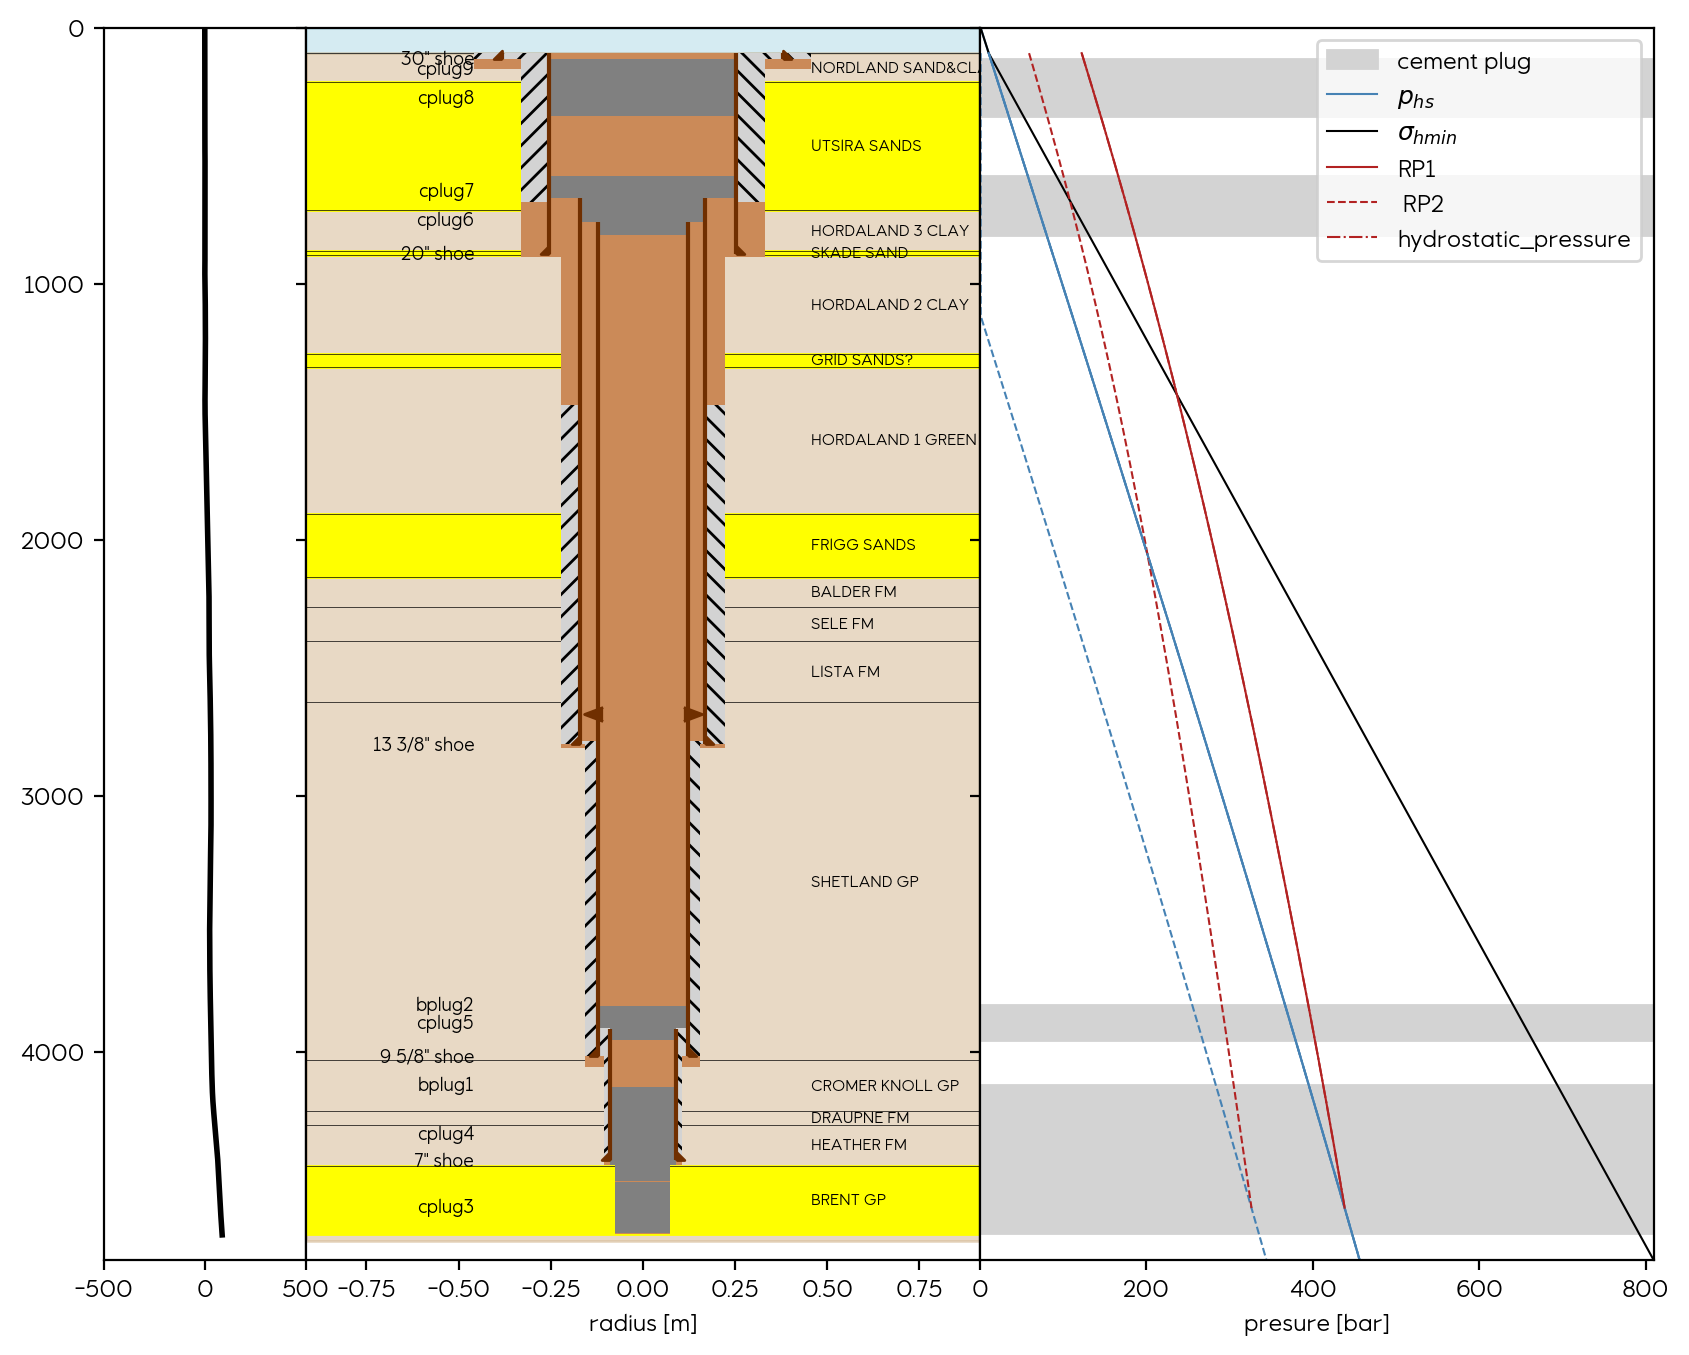

In [57]:
#Plot sketch, pressures
fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey=True, figsize=(10, 8), width_ratios=[0.3,1, 1])
plot_sketch(my_well, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2)

ax0.plot(os, w.location.tvd, lw=2, label="welly", c='k')
# ax0.set_aspect(1)
ax0.set_xlim(-500, 500)

#Draw casing shoes
perf_size = 3
left_perf = [[perf_size/3, -perf_size/2], [-perf_size, 0], [perf_size/3, perf_size/2]]
right_perf = [[-perf_size/3, -perf_size/2], [perf_size, 0], [-perf_size/3, perf_size/2]]


shoe_query = casings_df[casings_df['shoe']]
steelcolor = '#702F00'
ax1.scatter( ((9+5/8)*0.0254)/2, 2705-23.5, marker = right_perf, s=100, c=steelcolor, zorder=100, facecolors='none')
ax1.scatter(-((9+5/8)*0.0254)/2, 2705-23.5, marker = left_perf, s=100, c=steelcolor, zorder=100)

# for idx, row in shoe_query.iterrows():
#         ycoord = row['bottom_msl']
#         d_in = row['diameter_in']
#         shoe_label = float_to_fraction_inches(d_in)+' shoe'
#         ax.annotate(shoe_label, xy = (xcoord_left, ycoord), fontsize = txt_fs_left, va = 'center', ha='right')



fig.subplots_adjust(wspace=0)

# fig.tight_layout(w_pad=0)

In [39]:
(9+5/8)*0.0254

0.244475

In [32]:
casings_df  = pd.DataFrame(my_well.casings)

casings_df[casings_df['shoe']]

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl
0,126,148,30.000,126,148,True,0.762000,99.0,121.0,99.0,121.0
1,126,910,20.000,126,709,True,0.508000,99.0,883.0,99.0,682.0
2,693,2825,13.375,1500,2825,True,0.339725,666.0,2798.0,1473.0,2798.0
3,785,4043,9.625,2814,4043,True,0.244475,758.0,4016.0,2787.0,4016.0
4,3936,4451,7.000,3935,4451,True,0.177800,3909.0,4424.0,3908.0,4424.0


In [28]:
import pandas as pd
bmod = pd.DataFrame(my_well.barriers_mod)
bmod['diam_in'] = bmod['diameter_m']/0.0254
bmod

,b_name,top_msl,bottom_msl,diameter_m,diam_in
cplug9_0,cplug9,121.0,203.0,0.508000,20.000
cplug8_1,cplug8,203.0,343.0,0.508000,20.000
cplug7_2,cplug7,577.0,666.0,0.508000,20.000
cplug7_3,cplug7,666.0,694.0,0.339725,13.375
cplug6_3,cplug6,694.0,758.0,0.339725,13.375
cplug6_4,cplug6,758.0,808.0,0.244475,9.625
bplug2_4,bplug2,3815.0,3815.5,0.244475,9.625
cplug5_5,cplug5,3820.0,3909.0,0.244475,9.625
cplug5_6,cplug5,3909.0,3954.0,0.177800,7.000
bplug1_6,bplug1,4129.0,4129.5,0.177800,7.000


In [29]:
bh = pd.DataFrame(my_well.borehole)
bh['diam_in'] = bh['id_m']/0.0254
bh

,top_msl,bottom_msl,id_m,diam_in
0,99.0,666.0,0.508000,20.000
1,666.0,758.0,0.339725,13.375
2,758.0,3909.0,0.244475,9.625
3,3909.0,4443.0,0.177800,7.000
4,4443.0,4712.0,0.149225,5.875


In [75]:
c = pd.DataFrame(my_well.casings)
# c['diam_in'] = c['id_m']/0.0254
c

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl
0,126,148,30.000,126,148,True,0.762000,99.0,121.0,99.0,121.0
1,126,910,20.000,126,709,True,0.508000,99.0,883.0,99.0,682.0
2,693,2825,13.375,1500,2825,True,0.339725,666.0,2798.0,1473.0,2798.0
3,785,4043,9.625,2814,4043,True,0.244475,758.0,4016.0,2787.0,4016.0
4,3936,4451,7.000,3935,4451,True,0.177800,3909.0,4424.0,3908.0,4424.0


In [88]:
casings_df  = pd.DataFrame(my_well.casings)
drilling_df = pd.DataFrame(my_well.drilling)

well_concat = pd.concat([casings_df, drilling_df])
well_concat.sort_values(by='diameter_in', ascending=False, inplace=True)
well_concat

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl
0,126,189,36.000,NaN,NaN,NaN,0.914400,99.0,162.0,NaN,NaN
0,126,148,30.000,126.0,148.0,True,0.762000,99.0,121.0,99.0,121.0
1,189,923,26.000,NaN,NaN,NaN,0.660400,162.0,896.0,NaN,NaN
1,126,910,20.000,126.0,709.0,True,0.508000,99.0,883.0,99.0,682.0
2,923,2839,17.500,NaN,NaN,NaN,0.444500,896.0,2812.0,NaN,NaN
2,693,2825,13.375,1500.0,2825.0,True,0.339725,666.0,2798.0,1473.0,2798.0
3,2839,4085,12.250,NaN,NaN,NaN,0.311150,2812.0,4058.0,NaN,NaN
3,785,4043,9.625,2814.0,4043.0,True,0.244475,758.0,4016.0,2787.0,4016.0
4,4085,4470,8.375,NaN,NaN,NaN,0.212725,4058.0,4443.0,NaN,NaN
4,3936,4451,7.000,3935.0,4451.0,True,0.177800,3909.0,4424.0,3908.0,4424.0


In [89]:

top_z = well_concat['top_msl'].drop_duplicates().dropna().values
top_z.sort()

top_z

array([  99.,  162.,  666.,  758.,  896., 2812., 3909., 4058., 4443.])

In [93]:
z_query = well_concat.query('top_msl == 162')
z_query.query('diameter_m == diameter_m.min()')
z_query

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl
1,189,923,26.0,NaN,NaN,NaN,0.6604,162.0,896.0,NaN,NaN


In [98]:
diam = 1 + well_concat['diameter_m'].max()

diam

borehole = []
for z_value in top_z:
    
    z_query = well_concat.query('top_msl == @z_value')
    min_q = z_query.query('diameter_m == diameter_m.min()')

    print(f"at depth = {z_value} the min diam is {min_q.iloc[0]['diameter_m']/0.0254} in")
    if min_q.iloc[0]['diameter_m'] < diam:
        print('passed')
        borehole.append(min_q.iloc[0][['top_msl', 'bottom_msl', 'diameter_m']].values.tolist())
        diam = min_q.iloc[0]['diameter_m']

borehole = np.array(borehole)
print(borehole)
# borehole[:-1, 1] = borehole[1:, 0]
borehole[1:, 0] = borehole[:-1, 1]

borehole_df = pd.DataFrame(data=borehole, columns=['top_msl', 'bottom_msl', 'id_m'])
borehole_df

at depth = 99.0 the min diam is 20.0 in
passed
at depth = 162.0 the min diam is 26.0 in
at depth = 666.0 the min diam is 13.375 in
passed
at depth = 758.0 the min diam is 9.625 in
passed
at depth = 896.0 the min diam is 17.5 in
at depth = 2812.0 the min diam is 12.25 in
at depth = 3909.0 the min diam is 7.0 in
passed
at depth = 4058.0 the min diam is 8.375 in
at depth = 4443.0 the min diam is 5.875 in
passed
[[9.90000e+01 8.83000e+02 5.08000e-01]
 [6.66000e+02 2.79800e+03 3.39725e-01]
 [7.58000e+02 4.01600e+03 2.44475e-01]
 [3.90900e+03 4.42400e+03 1.77800e-01]
 [4.44300e+03 4.71200e+03 1.49225e-01]]


,top_msl,bottom_msl,id_m
0,99.0,883.0,0.508000
1,883.0,2798.0,0.339725
2,2798.0,4016.0,0.244475
3,4016.0,4424.0,0.177800
4,4424.0,4712.0,0.149225


In [24]:
pt_df = my_pressure.pressure_CO2

pt_df


,depth_msl,temp,hs_p,RHOH2O,Shmin,RP1_h2o,RP1_h2o_rho,RP1_co2,RP1_co2_rho,RP1_h2o_rho_in_co2_column,RP2_h2o,RP2_h2o_rho,RP2_co2,RP2_co2_rho,RP2_h2o_rho_in_co2_column,hydrostatic_pressure_h2o,hydrostatic_pressure_h2o_rho,hydrostatic_pressure_co2,hydrostatic_pressure_co2_rho,hydrostatic_pressure_h2o_rho_in_co2_column
0,0,4.00,1.0132500000,999.9748691400,1.0132500000,1.0132500000,999.9796389642,113.0918266333,961.7585720489,1005.4511402712,1.0132500000,999.9748691400,50.2962065152,914.7935169303,1002.3998669486,1.0132500000,999.9796389642,113.0918266333,961.7585720489,1005.4511402712
1,1,4.00,1.1113140355,999.9748691400,1.1113140355,1.1096513998,999.9844909937,113.1861429303,961.8150589011,1005.4556909829,1.0132500000,999.9748691400,50.3859171136,914.8806474217,1002.4042567443,1.1096513998,999.9844909937,113.1861429303,961.8150589011,1005.4556909829
2,2,4.00,1.2093785468,999.9797212284,1.2093785468,1.2077163789,999.9893429395,113.2804647668,961.8715198920,1005.4602418661,1.0132500000,999.9748691400,50.4756362566,914.9676962107,1002.4086468695,1.2077163789,999.9893429395,113.2804647668,961.8715198920,1005.4602418661
3,3,4.00,1.3074435340,999.9845732331,1.3074435340,1.3057818338,999.9941948013,113.3747921402,961.9279550518,1005.4647929205,1.0132500000,999.9748691400,50.5653639362,915.0546634854,1002.4130373240,1.3057818338,999.9941948013,113.3747921402,961.9279550518,1005.4647929205
4,4,4.00,1.4055089969,999.9894251538,1.4055089969,1.4038477645,999.9990465793,113.4691250480,961.9843644109,1005.4693441460,1.0132500000,999.9748691400,50.6551001444,915.1415494722,1002.4174281074,1.4038477645,999.9990465793,113.4691250480,961.9843644109,1005.4693441460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907,4907,196.32,464.6936870971,894.6994202126,825.6798964642,464.6936870971,894.6994202126,NaN,NaN,NaN,352.6527472671,891.7966732617,NaN,NaN,NaN,464.6936870971,894.6994202126,NaN,NaN,NaN
4908,4908,196.36,464.7814231560,894.6588168937,825.8493964642,464.7814231560,894.6588168937,NaN,NaN,NaN,352.7401991343,891.7608682686,NaN,NaN,NaN,464.7814231560,894.6588168937,NaN,NaN,NaN
4909,4909,196.40,464.8691552324,894.6182075565,826.0188964642,464.8691552324,894.6182075565,NaN,NaN,NaN,352.8276474898,891.7250588629,NaN,NaN,NaN,464.8691552324,894.6182075565,NaN,NaN,NaN
4910,4910,196.44,464.9568833259,894.5775921998,826.1883964642,464.9568833259,894.5775921998,NaN,NaN,NaN,352.9150923331,891.6892450445,NaN,NaN,NaN,464.9568833259,894.5775921998,NaN,NaN,NaN


In [25]:
import pandas as pd
pd.DataFrame(my_well.geology)

,top_rkb,geol_unit,reservoir_flag,top_msl,base_msl
0,126,NORDLAND SAND&CLAY,False,99.0,211.0
1,238,UTSIRA SANDS,True,211.0,711.0
2,738,HORDALAND 3 CLAY,False,711.0,873.0
3,900,SKADE SAND,True,873.0,889.0
4,916,HORDALAND 2 CLAY,False,889.0,1273.0
5,1300,GRID SANDS?,True,1273.0,1323.0
6,1350,HORDALAND 1 GREEN CLAY,False,1323.0,1899.0
7,1926,FRIGG SANDS,True,1899.0,2144.0
8,2171,BALDER FM,False,2144.0,2264.0
9,2291,SELE FM,False,2264.0,2396.0


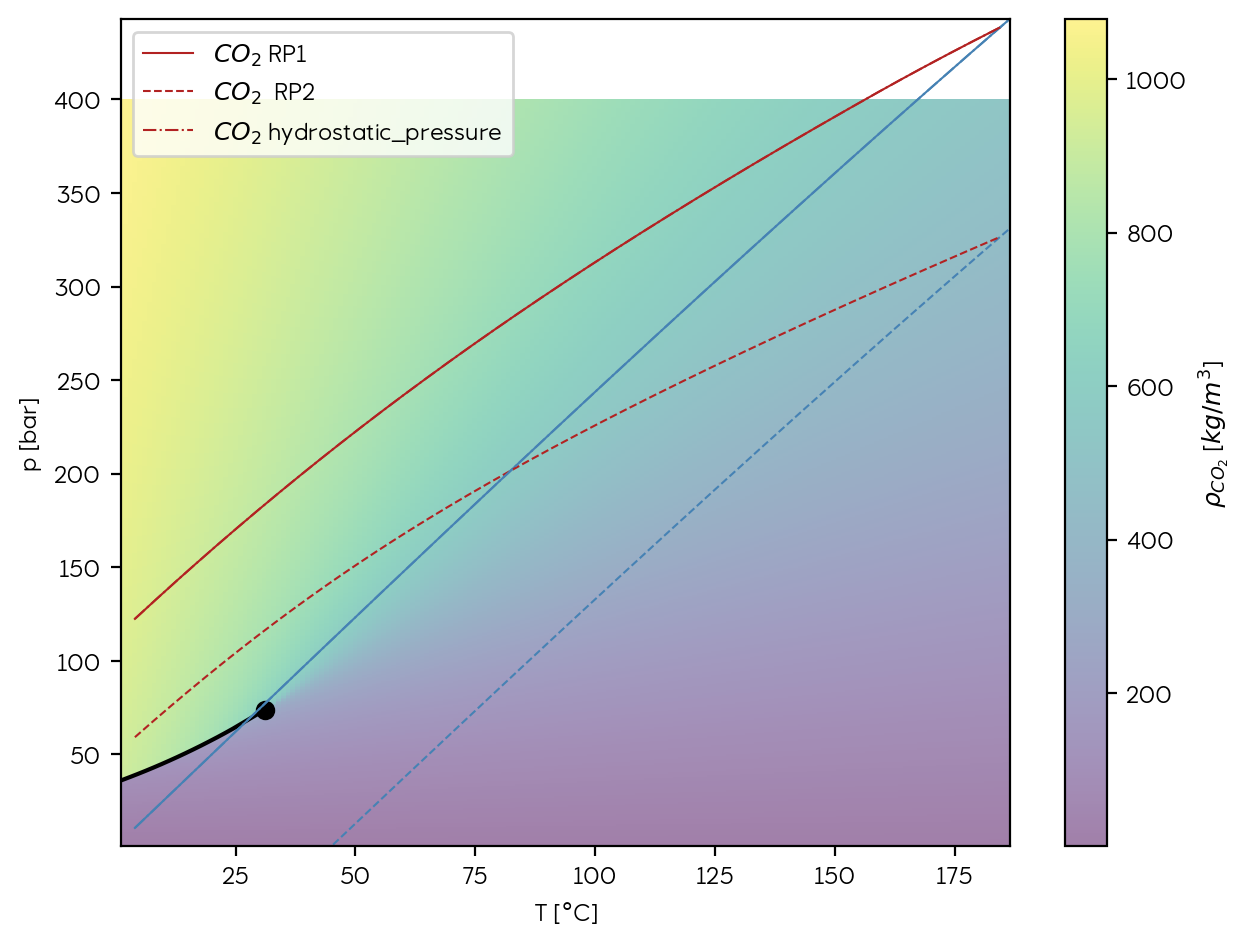

In [26]:
plot_pt(my_pressure)